## 1. Contexte
L’optimisation de la production des fruits rouges en serres est cruciale pour maximiser le rendement et la qualité des fruits tout en minimisant les coûts et l’impact environnemental. Ce document présente une analyse approfondie des différentes variétés de fruits, des méthodes de plantation, des scénarios de production, et des contraintes spécifiques associées.

Importation des librairies :

In [1]:
import pandas as pd
import numpy as np
import pulp
import datetime
import calendar

Importation des données à travers la librairie "pandas"

In [2]:
##Importation des base de donnes 

CVar = pd.read_csv("Charges_var.csv"  ) 
Prices = pd.read_csv("Prices.csv")
Production = pd.read_csv("Production.csv")
Simulation = pd.read_csv("Simulation.csv")


### Fonction `get_weeks_for_month` pour la conversion d'un mois aux semaines correspondantes

La fonction `get_weeks_for_month` permet de convertir un mois donné en les semaines correspondantes. Cette fonction est particulièrement utile pour des applications d'optimisation de la production où la gestion des périodes de plantation et de récolte est essentielle.


In [3]:
def get_weeks_for_month(month_name):  #Donner les semaines par ordre pour chaque mois de 2024
    
    month_to_weeks = {
        'janvier': [1, 2, 3, 4, 5],
        'fevrier': [6, 7, 8, 9],
        'mars': [10, 11, 12, 13],
        'avril': [14, 15, 16, 17,18],
        'mai': [19, 20, 21, 22],
        'juin': [23, 24, 25, 26],
        'juillet': [27, 28, 29, 30, 31],
        'aout': [32, 33, 34, 35],
        'septembre': [36, 37, 38, 39, 40],
        'octobre': [41, 42, 43, 44],
        'novembre': [45, 46, 47, 48],
        'decembre': [49, 50, 51, 52 ]
    }
    
    return month_to_weeks.get(month_name.lower(), "Month not recognized")

Exemple :

In [4]:
get_weeks_for_month('janvier')

[1, 2, 3, 4, 5]

## CA et CV
On doit calculer le chiffre d’affaire et charge variable par (serre, scenario et semaine de plantation).
\
\begin{align*}
CA(i, j, t') &= \sum_{t=0}^{37} \text{prod}(j, t) \times \text{surface}(i) \times \text{prix}(j, t' + t + \text{delai}(j)) \\
CV(i, j) &= \text{surface}(i) \times \text{Charges}(j)
\end{align*}
\
avec \( i \) la serre, \( j \) le scénario, et \( t' \) la semaine de plantation.

In [5]:
def CV(i,j) :
    return Simulation.loc[Simulation['serre'] == i ].iloc[0, 2]  * CVar.loc[CVar["Scénario"] == j].iloc[0 ,6]

In [6]:
D = { 'Framboise' : 0 , 'Mure' : 1} #dictionnaire utile pour trouver le prix en fonction de scenario


## Remarque

Il est important de noter que la base de données ne contient pas d'informations sur les prix pour une semaine au-delà de la 90ème. Par conséquent, deux options s'offrent à nous :

1. Annuler le revenu de toutes les semaines après la 90ème semaine.
2. Noter que la courbe des prix semble périodique, et choisir de vendre au prix de la semaine n-90 lorsque le numéro de la semaine n dépasse 90.

Cependant, dans le cadre de cette base de données, les deux choix conduisent à la même solution optimale.


In [7]:
def CA(i, j, t1) :     ##Calcule de chiffre d'affaire
    S = 0  
    for t in range(1,38):
        t_t1_Production = t + t1 + Production.loc[Production['Scénario'] == j].iloc[0,6]
        t_t1_Production_mod = ((t_t1_Production - 1) % 90) + 1

        S += Production.loc[Production['Scénario'] == j, f'W{t}'].iloc[0] * Simulation.loc[Simulation['serre'] == i].iloc[0,2] * Prices.iloc[D[Production.loc[Production['Scénario'] == j ,'Culture'].iloc[0]], t_t1_Production_mod]

        
    return S

## Modélisation
Le problème s'agit d'une MAXIMISATION


In [8]:
prob = pulp.LpProblem("Optimisation_Production_Fruits_Rouges", pulp.LpMaximize)     

## 1 Variables de Décision
La modélisation utilise des variables de décision représentées par un tenseur tridimensionnel de variables binaires.

Les variables de décision sont organisées dans un dictionnaire interprété comme un tenseur tridimensionnel de variables binaires, tel que :
 **X[ijk] = 1   si la serre \( i \) est choisie pour le scénario \( j \) et la semaine \( k \).**


In [9]:
X = {}   ## Variale de decision 
for i in Simulation.loc[:,'serre']:

    for j in Production.loc[:,'Scénario' ]:
        
        for t in get_weeks_for_month(Production.loc[Production['Scénario'] == j].loc[:, 'Mois'].iloc[0]):
            var_name = f"x_{i}_{j}_{t}"
            X[(i, j, t)] = pulp.LpVariable(var_name, cat='Binary')
            
            
            
        
        

#### 2 Formulation Mathématique
\
\begin{align*}
\text{maximize} \quad & \sum_{i=1}^{n_{\text{serre}}} \sum_{j \in \text{scénarios}} \sum_{t \in \text{(semaines de scénario(j))}} X(i, j, t) \cdot CA(i, j, t) - X(i, j, t) \cdot CV(i, j) \\
\text{subject to:} \quad & \sum_{j \in \text{scénarios}} \sum_{t \in \text{(semaines de scénario(j))}} X(i, j, t) = 1, \quad \forall i \in \{1, \dots, n_{\text{serre}}\} \\
& X(i, 5, t) = 0, \quad \forall i \in \{1, \dots, n_{\text{serre}}\}, \quad i \notin \text{secteur serre}(6), \quad \forall t \in \text{semaines de scénario(5)} \\
& X(i, 4, t) = 0, \quad \forall i \in \{1, \dots, n_{\text{serre}}\}, \quad i \notin \text{secteur serre}(6), \quad \forall t \in \text{semaines de scénario(4)} \\
& X(i, j, t) = 0, \quad \forall i \in \{1, \dots, n_{\text{serre}}\}, \quad i \notin \text{secteur serre}(5), \quad \forall j \in \{12, 13, 14, 18\}, \quad \forall t \in \text{(semaines de scénario(j))} \\
& X(i, j, t) = 0, \quad \forall i \in \{1, \dots, n_{\text{serre}}\}, \quad \text{surface serre}(i) > 2.87, \quad \forall j \in \{12, 13, 14, 18\}, \quad \forall t \in \text{semaines de scénario(j)}
\end{align*}



In [10]:
##Definition de la fonction objective
objective = pulp.lpSum(
    X[i, j, t] * CA(i, j, t) - X[i, j, t] * CV(i, j)
    for i in Simulation.loc[:,'serre']
    for j in Production.loc[:,'Scénario' ]
    for t in get_weeks_for_month(Production.loc[Production['Scénario'] == j, 'Mois'].iloc[0])
    
)



In [11]:
prob += objective

Contrainte : chaque serre admet un seul scenario

In [12]:
for i in Simulation.loc[:, 'serre'] :    ##Contrainte : chaque serre admet un seul scenario
    prob += pulp.lpSum(X[i, j, t] 
                       for j in Production.loc[:,'Scénario' ] 
                       for t in get_weeks_for_month(Production.loc[Production['Scénario'] == j, 'Mois'].iloc[0])
                      ) == 1

Contraintes spécifiques (voir formulation mathématique)

In [13]:
secteur_6_serres = Simulation.loc[Simulation['secteur'] == 6, 'serre'].tolist()
secteur_5_serres = Simulation.loc[Simulation['secteur'] == 5, 'serre'].tolist()
surface_sup_287 = Simulation.loc[Simulation['SAU(ha)'] > 2.78, 'serre'].tolist()
grouped_sectors = Simulation.groupby('secteur')['serre'].apply(list).to_dict()

In [14]:
for i in Simulation.loc[:, 'serre']:


    ##Scénarios 4 et 5: Ne peuvent être exécutés que dans le secteur 6.
    if not i in secteur_6_serres :  
        for t in get_weeks_for_month(Production.loc[Production['Scénario'] == 5, 'Mois'].iloc[0]):
            prob += X[i, 5, t] == 0
           
        for t in get_weeks_for_month(Production.loc[Production['Scénario'] == 4, 'Mois'].iloc[0]):
           
            prob += X[i, 4, t] == 0

##Scénarios 12, 13, 14, 18: Limitées au secteur 5.
    if not i in secteur_5_serres :
        for j in [12, 13, 14, 18] :
            for t in  get_weeks_for_month(Production.loc[Production['Scénario'] == j, 'Mois'].iloc[0]):
                prob += X[i, j, t] == 0

Scénarios 12, 13, 14, 18 : Limitées aux serres de moins de 2.87 hectares.

Cette contrainte n'a pas d'impact car la base de données ne contient pas de serres dépassant cette taille. Elle est donc redondante pour cette base de données.


In [15]:
 if i in surface_sup_287 :
        for j in [12, 13, 14, 18]: 
            for t in  get_weeks_for_month(Production.loc[Production['Scénario'] == j, 'Mois'].iloc[0]):
                prob += X[i, j, t] == 0


Secteur doit avoir le même scénario choisi pour toutes ses serres.

Cette contrainte ne change rien sur le résultat (peut être la base de donnée n'est pas assez grand pour remarquer la différence)

In [16]:
for secteur, serres in grouped_sectors.items():
   
        for j in Production['Scénario']:
            for t in get_weeks_for_month(Production.loc[Production['Scénario'] == j, 'Mois'].iloc[0]):
              for s1 in serres:
                for s2 in serres:
                    if s1 != s2:
                        prob += pulp.lpSum(X[s1, j, t] - X[s2, j, t]) == 0

## Résolution de problème :

In [17]:
prob.solve()   ##Il ya une feasible solution

1

Il existe une solution OPTIMALE

In [18]:
pulp.LpStatus[prob.status]

'Optimal'

Pour avoir tout les valeurs de la solution optimale

In [19]:
#for v in prob.variables():
    #print(v.name, "=", v.varValue)

## Plottage de la solution optimale :

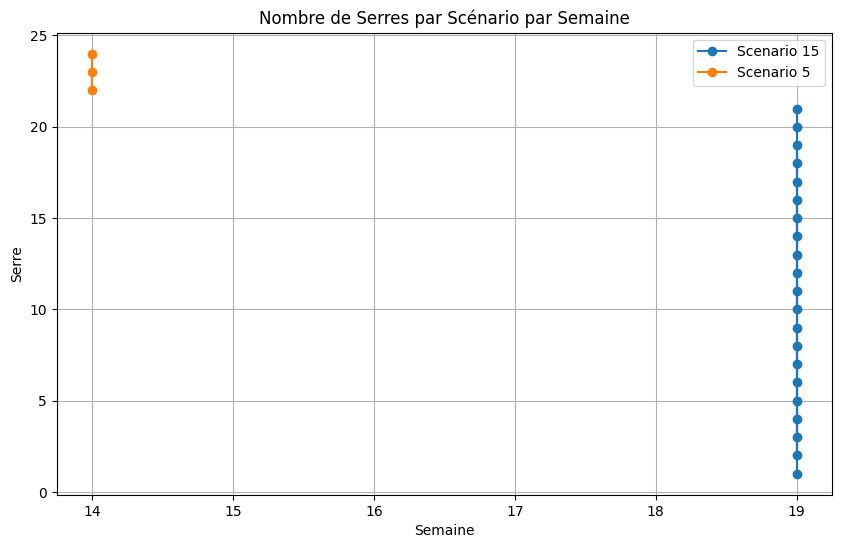

In [20]:
## Ploting des solutions

import pandas as pd
import matplotlib.pyplot as plt


solution = []
for v in prob.variables():
    name = v.name
    value = v.varValue
    if value != 0:  
        parts = name.split('_')
        serre = int(parts[1])
        scenario = int(parts[2])
        week = int(parts[3])
        solution.append((serre, scenario, week, value))


df_solution = pd.DataFrame(solution, columns=['Serre', 'Scenario', 'Week', 'Value'])


plt.figure(figsize=(10, 6))
for scenario in df_solution['Scenario'].unique():
    subset = df_solution[df_solution['Scenario'] == scenario]
    plt.plot(subset['Week'], subset['Serre'], marker='o', label=f'Scenario {scenario}')

plt.xlabel('Semaine')
plt.ylabel('Serre')
plt.title('Nombre de Serres par Scénario par Semaine')
plt.legend()
plt.grid(True)
plt.show()

### Valeur de la fonction objective :

In [21]:
pulp.value(prob.objective)   ## Solution optimale 

9577487.5

## Remarque :
Il est important de noter que la solution optimale est très sensible à la fonction `get_weeks_for_month`, qui donne les semaines par ordre pour chaque mois de 2024.

Le problème réside dans le fait qu'une semaine peut être répartie entre deux mois. Prenons l'exemple des mois d'avril et de mai : si nous considérons que la semaine 18 appartient à mai, nous trouvons comme valeur maximale de la fonction objectif **9,5 millions**. Cependant, si nous la comptons avec avril, nous trouvons **11 millions**.

## Remerciements

Nous tenons à remercier **Anasse ESSALIH** pour ce projet très intéressant, ainsi que pour son engagement à répondre à toutes nos questions.

Bien que les calculs manuels du **simplexe** aient été frustrants, la transition vers le codage nous a permis d'apprécier la beauté de la matière.